### 根据之前分好的数据集，提取特征，使用基于CNN+MLP的神经网络测试效果
### 训练好模型后，预测另外一天的数据，测试表现
### 由于使用的数据量不同，后续结果会有变化

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os,time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from joblib import dump, load
import librosa.display
from utils import data_process, visualize
from utils.utils import train, test, summary, setup_seed
from utils.models import Att_CNN, CNN

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [64]:
# 读取数据
X =np.load('/home/yuanshao/EQ_Place/code/data/X_8_29.npy', allow_pickle=True)
Y =np.load('/home/yuanshao/EQ_Place/code/data/Y_8_29.npy')

pd.value_counts(Y)

0    1288
1     571
dtype: int64

In [6]:
# 统一长度

for i in range(len(X)):
    if X[i][0].shape[0]!=7201:
        X[i][0]=data_process.data_resample( X[i][0], 7201)
        X[i][1]=data_process.data_resample( X[i][1], 7201)
        X[i][2]=data_process.data_resample( X[i][2], 7201)

In [7]:
# 特征提取
feature = []
for i in tqdm(range(len(X))):
    ex, ey, ez = X[i][0], X[i][1], X[i][2]
    iqr_x = data_process.cal_IQR(ex)
    iqr_y = data_process.cal_IQR(ey)
    iqr_z = data_process.cal_IQR(ez)
    zcr_x = data_process.ZCR(ex)
    zcr_y = data_process.ZCR(ey)
    zcr_z = data_process.ZCR(ez)
    cav=data_process.CAV([ex,ey,ez])
    feature.append([iqr_x, iqr_y, iqr_z ,zcr_x, zcr_y, zcr_z, cav])
feature=np.array(feature)
feature=feature[:,:,np.newaxis,:]  
# np.save('feature_8_29',feature)

100%|██████████| 1859/1859 [00:39<00:00, 46.64it/s]


In [5]:
feature.shape

(1859, 7, 1, 36)

In [8]:
# X = np.load('./data/feature_8_29.npy')
# Y =np.load('/home/xxx/EQ_Place/code/data/Y_8_29.npy')
x_train, x_test, y_train, y_test = train_test_split(feature, Y,test_size=0.2, 
                                                     random_state=1)


x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()
traindata =TensorDataset(x_train,y_train)
testdata = TensorDataset(x_test,y_test)
train_loader = DataLoader(traindata,batch_size = 256,shuffle=True)
test_loader = DataLoader(testdata,batch_size=256,shuffle=True)

In [9]:
x_test.shape

torch.Size([372, 7, 1, 36])

In [10]:
%%time
setup_seed(20)
# model = Att_CNN().cuda()
model = CNN().cuda()
L = []
test_hist = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1, 100 + 1):
    start = time.time()
    loss = train(model, train_loader, optimizer, epoch)
    L.append(loss)
    print("time {:.1f} sec:".format(time.time() - start))
    acc = test(model, test_loader)
    test_hist.append(acc)

Train Epoch: 1, Average Loss: 0.6628
time 0.1 sec:
Test set: Average loss: 0.6165, Accuracy: 261/372 (70.16%)

Train Epoch: 2, Average Loss: 0.6239
time 0.1 sec:
Test set: Average loss: 0.5983, Accuracy: 261/372 (70.16%)

Train Epoch: 3, Average Loss: 0.6099
time 0.1 sec:
Test set: Average loss: 0.5823, Accuracy: 262/372 (70.43%)

Train Epoch: 4, Average Loss: 0.5938
time 0.1 sec:
Test set: Average loss: 0.5584, Accuracy: 279/372 (75.00%)

Train Epoch: 5, Average Loss: 0.5644
time 0.1 sec:
Test set: Average loss: 0.5309, Accuracy: 282/372 (75.81%)

Train Epoch: 6, Average Loss: 0.5439
time 0.1 sec:
Test set: Average loss: 0.5139, Accuracy: 278/372 (74.73%)

Train Epoch: 7, Average Loss: 0.5385
time 0.1 sec:
Test set: Average loss: 0.5415, Accuracy: 264/372 (70.97%)

Train Epoch: 8, Average Loss: 0.5496
time 0.1 sec:
Test set: Average loss: 0.5168, Accuracy: 280/372 (75.27%)

Train Epoch: 9, Average Loss: 0.5268
time 0.1 sec:
Test set: Average loss: 0.5148, Accuracy: 284/372 (76.34%)

T

Train Epoch: 75, Average Loss: 0.2840
time 0.0 sec:
Test set: Average loss: 0.3281, Accuracy: 325/372 (87.37%)

Train Epoch: 76, Average Loss: 0.2874
time 0.0 sec:
Test set: Average loss: 0.3205, Accuracy: 326/372 (87.63%)

Train Epoch: 77, Average Loss: 0.2785
time 0.0 sec:
Test set: Average loss: 0.3052, Accuracy: 329/372 (88.44%)

Train Epoch: 78, Average Loss: 0.2746
time 0.0 sec:
Test set: Average loss: 0.3177, Accuracy: 327/372 (87.90%)

Train Epoch: 79, Average Loss: 0.2868
time 0.0 sec:
Test set: Average loss: 0.3482, Accuracy: 325/372 (87.37%)

Train Epoch: 80, Average Loss: 0.2900
time 0.0 sec:
Test set: Average loss: 0.3056, Accuracy: 330/372 (88.71%)

Train Epoch: 81, Average Loss: 0.2707
time 0.0 sec:
Test set: Average loss: 0.3093, Accuracy: 329/372 (88.44%)

Train Epoch: 82, Average Loss: 0.2975
time 0.0 sec:
Test set: Average loss: 0.3248, Accuracy: 328/372 (88.17%)

Train Epoch: 83, Average Loss: 0.2919
time 0.0 sec:
Test set: Average loss: 0.3059, Accuracy: 332/372 (8

In [11]:
x_test = x_test.cuda()
y_test = y_test.cuda()

pred = model(x_test)
pred = pred.max(1, keepdim=True)[1]
correct = pred.eq(y_test.view_as(pred)).sum().item()
pred = pred.cpu().numpy().squeeze()

summary(pred, y_test.cpu())

confusion matrix:
 [[256  32]
 [  5  79]]
Roc score: 0.9147
F1 score: 0.8103
              precision    recall  f1-score   support

           0       0.98      0.89      0.93       288
           1       0.71      0.94      0.81        84

    accuracy                           0.90       372
   macro avg       0.85      0.91      0.87       372
weighted avg       0.92      0.90      0.90       372



In [131]:
# 以当天的数据训练的模型 去测试另外一天的数据
X = np.load('./X_2_15.npy', allow_pickle=True)
Y = np.load('./Y_2_15.npy')

In [132]:
# 统一长度
new_X=[]
for i in range(len(X)):
    if X[i][0].shape[0]!=7201:
        ex=data_process.data_resample( X[i][0], 7201)
        ey=data_process.data_resample( X[i][1], 7201)
        ez=data_process.data_resample( X[i][2], 7201)
        new_X.append([ex,ey,ez])
X=np.array(new_X)
feature = []
for i in tqdm(range(len(X))):
    ex, ey, ez = X[i][0], X[i][1], X[i][2]
    iqr_x = data_process.cal_IQR(ex)
    iqr_y = data_process.cal_IQR(ey)
    iqr_z = data_process.cal_IQR(ez)
    zcr_x = data_process.ZCR(ex)
    zcr_y = data_process.ZCR(ey)
    zcr_z = data_process.ZCR(ez)
    cav=data_process.CAV([ex,ey,ez])
    feature.append([iqr_x, iqr_y, iqr_z ,zcr_x, zcr_y, zcr_z, cav])
feature=np.array(feature)
feature=feature[:,:,np.newaxis,:]  

100%|██████████| 232/232 [00:04<00:00, 47.97it/s]


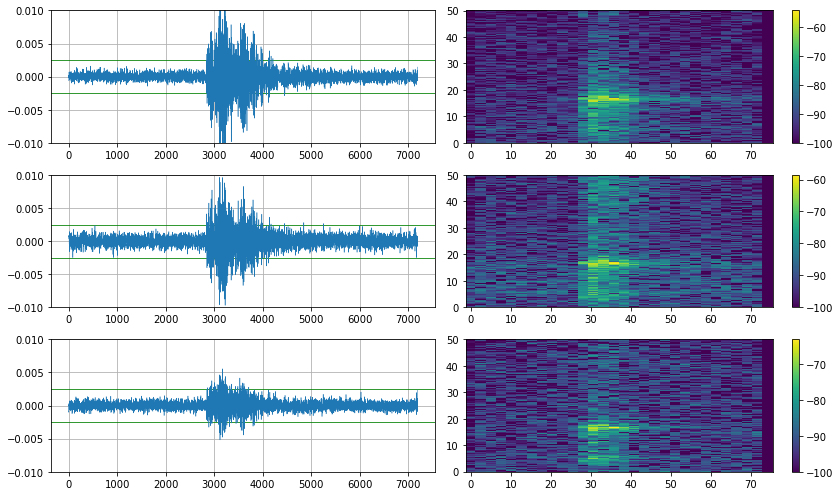

In [133]:
visualize.draw_picture(X[0], show=True, save_path=None, lim=0.01,save=False)

In [128]:
feature.shape

(414, 7, 1, 36)

In [129]:
pd.value_counts(Y)

0    370
1     44
dtype: int64

In [134]:
X = torch.from_numpy(feature).float()
Y = torch.from_numpy(Y).long()
X = X.cuda()
Y = Y.cuda()


pred = model(X)
pred = pred.max(1, keepdim=True)[1]
correct = pred.eq(Y.view_as(pred)).sum().item()
pred = pred.cpu().numpy().squeeze()

summary(pred, Y.cpu())

confusion matrix:
 [[105   0]
 [ 57  70]]
Roc score: 0.7756
F1 score: 0.7107
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       105
           1       1.00      0.55      0.71       127

    accuracy                           0.75       232
   macro avg       0.82      0.78      0.75       232
weighted avg       0.84      0.75      0.74       232

